In [307]:
import numpy as np
from sklearn import datasets

from NPIR import NPIR
import pandas as pd
from sklearn.datasets import make_blobs
import datetime
import warnings
from sklearn import metrics
from collections import Counter as Cs
from timeit import default_timer as timer
from datetime import timedelta
import matplotlib.pyplot as plt


import findspark
findspark.init()
from pyspark import SparkContext
from operator import *
from pyspark import StorageLevel

from pyspark.sql.types import IntegerType, FloatType, BooleanType, StringType, StructType,\
StructField,ArrayType, DataType
from pyspark.sql.functions import udf, log, rand, monotonically_increasing_id, col, broadcast,\
greatest,desc,asc, row_number, avg, mean, least, struct, lit, sequence
from functools import reduce

import pyspark.sql.functions as F

from pyspark.sql import SparkSession, SQLContext, Window, Row, DataFrame
from pyspark import SparkConf

In [103]:
spark = SparkSession.builder.master("local[*]").config("spark.sql.broadcastTimeout", "30000s").\
config("spark.network.timeout","30000s").config("spark.executor.heartbeatInterval","12000000ms").\
config("spark.storage.blockManagerSlaveTimeoutMs","12000001ms").config("spark.driver.maxResultSize","12g").\
config("spark.default.parallelism", "100").config("spark.memory.offHeap.enabled","true").\
config("spark.memory.offHeap.size", "25g").appName("NPIR_Parallel").getOrCreate()

In [104]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [105]:
#read csv
data_spark_df = spark.read.format('csv').option('header','False').option('index','False').load('blobs.csv')
data_spark_df.count()

1500

In [106]:
data_spark_df.describe()

DataFrame[summary: string, _c0: string, _c1: string, _c2: string]

In [107]:
data_spark_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)



In [195]:
data_spark_df = data_spark_df.select('_c0', '_c1')

In [196]:
new_name = ['first', 'second']
data_spark_rdd = data_spark_df.toDF(*new_name).rdd.filter(lambda x:x)
data_spark_df = data_spark_df.toDF(*new_name)

In [197]:
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
spark.conf.set('spark.jars.packages','com.databricks:spark-cav_2.11')
spark.conf.set("spark.sql.parquet.compression.codec","gzip")
spark.conf.set("spark.sql.execution.arrow.enabled", "False")
sqlContext.setConf("spark.sql.shuffle.partitions", "10")

In [198]:
# def MyCheckUpdate(a, b, c, d):
#     a = float(a)
#     b = float(b)
#     c = float(c)
#     d = float(d)
#     res = (a-c) + (b-d)
#     if res == 0:
#         return 1.0
#     return 0.0

In [199]:
# check_centroid = udf(lambda x,y,z,r: MyCheckUpdate(x,y,z,r), FloatType())

In [200]:
# def squaree1(c,u,f,g):
#     c = float(c)
#     u = float(u)
#     f = float(f)
#     g = float(g)
#     array1 = np.array([c,u])
#     array2 = np.array([f,g])
#     dist = np.linalg.norm(array1-array2)
#     dist = dist.item()
#     return dist

In [201]:
# squaree_spark1 = udf(lambda x,y,z,r: squaree1(x,y,z,r), FloatType())
# sqlContext.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

In [202]:
# data_spark_df = data_spark_df.withColumn("first_numeric", data_spark_df["first"].cast(FloatType()))
# data_spark_df

In [203]:
# data_spark_df = data_spark_df.withColumn("second_numeric", data_spark_df["second"].cast(FloatType()))
# data_spark_df

In [204]:
# data_spark_df = data_spark_df.drop('first').drop('second')
# data_spark_df

In [205]:
# df_centroid = data_spark_df.sample(False, 0.4,seed = 0).limit(1).cache()

# new_name = ['x','y']
# df_centroid = df_centroid.toDF(*new_name)

In [206]:
# df_centroid.show()

In [207]:
# df_centroid.show()

In [208]:
# #just for first round
# #first time
# i = 0

# data_cent = data_spark_df.join(broadcast(df_centroid))
# data_cent.show()

In [209]:
# data_cent1 = data_cent.withColumn(str(i),squaree_spark1(data_cent.columns[0],data_cent.columns[1],
#                                               data_cent.columns[2*i+2],data_cent.columns[2*i+3]))
# data_cent1.show()

In [210]:
# data_cent2 = data_cent1.drop(data_cent1.columns[i+2]).drop(data_cent1.columns[i+3])
# data_cent2.show()

In [211]:
# data_cent3 = data_cent2.withColumn('mindist',col(str(i)))
# data_cent3.show()

In [212]:
# data_cent4 = data_cent3.withColumn('mindist1',least(data_cent3.columns[i+2], col('mindist')))
# data_cent4 = data_cent4.drop('mindist')
# data_cent4.show()

In [213]:
# data_cent5 = data_cent4.withColumnRenamed('mindist1','mindist')

In [214]:
# next_selected = data_cent5.orderBy(desc('mindist')).limit(1).select(data_cent5.columns[0:2])#1:3
# next_selected.show()

In [215]:
# df_centroid = df_centroid.union(next_selected)

In [216]:
# u = [str(i)+'x',str(i)+'y']
# next_selected = next_selected.toDF(*u)
# next_selected.show()

In [217]:
# def initial_centroids(next_selected,data_cent_5_persist, i):
#     data_cent6 = data_cent_5_persist.join(broadcast(next_selected))
#     data_cent6 = data_cent6.withColumn(str(i),squaree_spark1(data_cent6.columns[0],data_cent6.columns[1],
#                                              data_cent6.columns[i+3],data_cent6.columns[i+4]))#+4 +5
#     data_cent6 = data_cent6.drop(data_cent6.columns[i+3]).drop(data_cent6.columns[i+4])#+4 +5
#     data_cent6 = data_cent6.withColumn('mindist1',least(data_cent6.columns[i+3], col('mindist')))#4
#     data_cent6 = data_cent6.drop('mindist')
#     data_cent6 = data_cent6.withColumnRenamed('mindist1','mindist')
#     next_cent = data_cent6.orderBy(desc('mindist')).limit(1).select(data_cent6.columns[0:2])#1:3
#     return next_cent,data_cent6

In [218]:
# data_cent_5_persist = data_cent5.persist(StorageLevel.MEMORY_ONLY_2)
# data_cent_5_persist.show()

In [219]:
# k=4

In [220]:
# start = timer()
# for i in range(1,k-1):
#     next_selected, data_cent_5_persist = initial_centroids(next_selected,data_cent_5_persist, i)
#     u = [str(i)+'x',str(i)+'y']
#     next_selected = next_selected.toDF(*u)

In [221]:
# i= k-1
# data_cent11 = data_cent_5_persist.join(broadcast(next_selected))
# data_cent11 = data_cent11.withColumn(str(i),squaree_spark1(data_cent11.columns[0],data_cent11.columns[1],
#                                                            data_cent11.columns[k+2],data_cent11.columns[k+3]))
# data_cent11 = data_cent11.drop('mindist').drop(data_cent11.columns[k+2]).drop(data_cent11.columns[k+3])
# data_cent11.show()

In [222]:
# def FindMinCOl( *row_list):
#     ind = row_list.index(min(*row_list))
#     return int(ind)

In [223]:
# find_min_val_name = udf(FindMinCOl, IntegerType())

In [224]:
# data_cent14 = data_cent11.withColumn('defined_cluster',find_min_val_name(*data_cent11.columns[2:3+k]))
# data_cent14 = data_cent14.select('first_numeric','second_numeric','defined_cluster')
# data_cent14.show()

In [225]:
# new_centroid = data_cent14.groupBy('defined_cluster').avg('first_numeric', 'second_numeric')
# new_centroid.show()

In [226]:
# spark.sparkContext.getConf().getAll()

In [227]:
# spark.conf.get("spark.sql.shuffle.partitions") 

In [228]:
# def UpdateCentroid(x):
#     data_cent_join1 = data_spark_df.join(broadcast(x))
#     data_cent_join2 = data_cent_join1.withColumn('dist',squaree_spark1(data_cent_join1.columns[0], 
#                                                                        data_cent_join1.columns[1],
#                                            data_cent_join1.columns[3],data_cent_join1.columns[4]))#3 4
#     w = Window.partitionBy(data_cent_join2.columns[1])
#     next_centroid = data_cent_join2.withColumn('mindist', F.min('dist').over(w)).\
#     filter(col('dist') == col('mindist')).drop('dist')
#     update_new_centroid = next_centroid.groupBy('defined_cluster').avg('first_numeric', 'second_numeric')
#     return update_new_centroid, next_centroid

In [229]:
# new_centroid_persist|first|second = new_centroid.persist(StorageLevel.MEMORY_AND_DISK)

In [230]:
# final_data = new_centroid

In [231]:
# start = timer()
# for i in range(20):
#     new_centroid_persist, final_data = UpdateCentroid(new_centroid_persist)

In [232]:
# end = timer()
# print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

In [233]:
# final_data = final_data.withColumnRenamed('avg(first_numeric)','cent_x').withColumnRenamed('avg(second_numeric)','cent_y')
# final_data1 = final_data.select('defined_cluster')
# final_data1.count()

In [234]:
# final_data3 = final_data1.toPandas()

In [235]:
# #read csv
# true_label = spark.read.format('csv').option('header','False').option('index','True').load('seeds.csv')
# true_label = true_label.select('_c7')
# true_label_list = final_data1.toPandas()
# true_label_list
# true_label.toPandas()

In [236]:
# type(final_data1)

In [237]:
# final_data.coalesce(1).write.csv('kmeans_output11.csv')
# final_data1.coalesce(1).write.csv('cluster_label_718.csv')
# # final_data1.write.csv('cluster_label_718.csv')
# # final_data.repartition(1).write.csv('kmeans_output11.csv')

In [238]:
# x,y  = make_blobs(n_samples=200, centers=3, n_features=2, random_state=0)

In [239]:
# from sklearn.cluster import KMeans

In [240]:
# x1,y1 = make_blobs(n_samples=100, centers=3, n_features=2,
#                 random_state=1)

In [241]:
points = data_spark_df.count()

In [246]:
#IR: The indexing ratio to be used for generating the maximum index
IR = 0.2
#The number of iteration i
i = 5
k = 3 #k: Number of clusters
# count = Cs()
chunk = 300


In [247]:
# start = timer()
# kmeans = KMeans(n_clusters=k, random_state=0).fit(x)
# end = timer()
# print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

In [248]:
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window

data_spark = data_spark_df.withColumn('index_column_name', row_number().\
                                          over(Window.orderBy(monotonically_increasing_id())) - 1)
# data_spark.show()

In [249]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [250]:
leaderheadr = ['chunkLabel', 'old label']
leaderheadr.extend([str(x) for x in range(1, len(data_spark.columns))])
leaderheadr = tuple(leaderheadr)
leaderheadr

('chunkLabel', 'old label', '1', '2')

In [251]:
labelsheader = ('chunkLabel', 'label')
labelsheader

('chunkLabel', 'label')

In [252]:
labels = sqlContext.createDataFrame([np.full(len(labelsheader), np.nan).tolist()],labelsheader)
labels = labels.na.drop()

leaders = sqlContext.createDataFrame([np.full(len(leaderheadr), np.nan).tolist()],leaderheadr)
leaders = leaders.na.drop()

ii = 0
for z in range(0, points, chunk):
    j = z + chunk
    data = data_spark.where(col("index_column_name").between(z, j-1)).toPandas()
    data.drop("index_column_name",axis=1,inplace=True)
    data = data.astype(float)
    from NPIR import NPIR
    label = NPIR(data.values,k,IR,i)
    data['labels'] = label

    # Adding to pyspard label
    chunklabel = np.full(len(label), ii).tolist()
    labelDF = [(x, y) for x, y in zip(chunklabel, label)]
    labelsDF = sqlContext.createDataFrame(labelDF,labelsheader)
    labels = unionAll(labels, labelsDF)

    leader = []
    f = list(Cs(label))
    f.sort()
    for i in f:
        leader.append([round(np.mean(z), 4) for z in data[data['labels']==i].values[:,:-1].T])
    del data
    del NPIR
    
    # Adding to pyspark leaders
    for x in range(len(leader)):
        x1 = [ii, x]
        
        x1.extend(leader[x])
        leader[x] = x1
        
    leaderDF = sqlContext.createDataFrame(leader,leaderheadr)
    leaders = unionAll(leaders, leaderDF)
    ii += 1

In [253]:
leader


[[4, 0, -5.4577, -9.9459], [4, 1, 7.3161, 0.7877], [4, 2, 7.5252, 9.4987]]

In [254]:
# leaders.where(col("chunkLabel").between(0, 0)).show()

In [255]:
# labels.show()

In [256]:
data_spark = leaders.withColumn("first_numeric", leaders["1"].cast(FloatType()))
data_spark = data_spark.withColumn("second_numeric", data_spark["2"].cast(FloatType()))
data_spark = data_spark.drop('1').drop('2').drop('chunkLabel').drop('old label')
data_spark = data_spark.drop('1').drop('2').drop('chunkLabel').drop('old label')
# data_spadf

In [257]:
def MyCheckUpdate(a, b, c, d):
    a = float(a)
    b = float(b)
    c = float(c)
    d = float(d)
    res = (a-c) + (b-d)
    if res == 0:
        return 1.0
    return 0.0

check_centroid = udf(lambda x,y,z,r: MyCheckUpdate(x,y,z,r), FloatType())

def squaree1(c,u,f,g):
    c = float(c)
    u = float(u)
    f = float(f)
    g = float(g)
    array1 = np.array([c,u])
    array2 = np.array([f,g])
    dist = np.linalg.norm(array1-array2)
    dist = dist.item()
    return dist

squaree_spark1 = udf(lambda x,y,z,r: squaree1(x,y,z,r), FloatType())
sqlContext.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

DataFrame[key: string, value: string]

In [258]:
df_centroid = data_spark.sample(False, 0.4,seed = 0).limit(1).cache()

new_name = ['x','y']
df_centroid = df_centroid.toDF(*new_name)

#just for first round
#first time
i = 0
data_cent = data_spark.join(broadcast(df_centroid))
data_cent1 = data_cent.withColumn(str(i),squaree_spark1(data_cent.columns[0],data_cent.columns[1],
                                              data_cent.columns[2*i+2],data_cent.columns[2*i+3]))
data_cent2 = data_cent1.drop(data_cent1.columns[i+2]).drop(data_cent1.columns[i+3])
data_cent3 = data_cent2.withColumn('mindist',col(str(i)))
data_cent4 = data_cent3.withColumn('mindist1',least(data_cent3.columns[i+2], col('mindist')))
data_cent4 = data_cent4.drop('mindist')
data_cent5 = data_cent4.withColumnRenamed('mindist1','mindist')
next_selected = data_cent5.orderBy(desc('mindist')).limit(1).select(data_cent5.columns[0:2])#1:3
df_centroid = df_centroid.union(next_selected)
u = [str(i)+'x',str(i)+'y']
next_selected = next_selected.toDF(*u)
def initial_centroids(next_selected,data_cent_5_persist, i):
    data_cent6 = data_cent_5_persist.join(broadcast(next_selected))
    data_cent6 = data_cent6.withColumn(str(i),squaree_spark1(data_cent6.columns[0],data_cent6.columns[1],
                                             data_cent6.columns[i+3],data_cent6.columns[i+4]))#+4 +5
    data_cent6 = data_cent6.drop(data_cent6.columns[i+3]).drop(data_cent6.columns[i+4])#+4 +5
    data_cent6 = data_cent6.withColumn('mindist1',least(data_cent6.columns[i+3], col('mindist')))#4
    data_cent6 = data_cent6.drop('mindist')
    data_cent6 = data_cent6.withColumnRenamed('mindist1','mindist')
    next_cent = data_cent6.orderBy(desc('mindist')).limit(1).select(data_cent6.columns[0:2])#1:3
    return next_cent,data_cent6


data_cent_5_persist = data_cent5.persist(StorageLevel.MEMORY_ONLY_2)


# start = timer()
for i in range(1,k-1):
    next_selected, data_cent_5_persist = initial_centroids(next_selected,data_cent_5_persist, i)
    u = [str(i)+'x',str(i)+'y']
    next_selected = next_selected.toDF(*u)

# end = timer()
# print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))



i= k-1
data_cent11 = data_cent_5_persist.join(broadcast(next_selected))
data_cent11 = data_cent11.withColumn(str(i),squaree_spark1(data_cent11.columns[0],data_cent11.columns[1],\
                                                           data_cent11.columns[k+2],data_cent11.columns[k+3]))
data_cent11 = data_cent11.drop('mindist').drop(data_cent11.columns[k+2]).drop(data_cent11.columns[k+3])


def FindMinCOl( *row_list):
    ind = row_list.index(min(*row_list))
    return int(ind)



find_min_val_name = udf(FindMinCOl, IntegerType())
data_cent14 = data_cent11.withColumn('defined_cluster', find_min_val_name(*data_cent11.columns[2:3+k]))
data_cent14 = data_cent14.select('first_numeric','second_numeric','defined_cluster')

# data_cent14.filter(col("defined_cluster") == 2).show()
new_centroid = data_cent14.groupBy('defined_cluster').avg('first_numeric', 'second_numeric')

spark.sparkContext.getConf().getAll()
spark.conf.get("spark.sql.shuffle.partitions") 

def UpdateCentroid(x):
    data_cent_join1 = data_spark.join(broadcast(x))
    data_cent_join2 = data_cent_join1.withColumn('dist',squaree_spark1(data_cent_join1.columns[0],
                                                                 data_cent_join1.columns[1],
                                       data_cent_join1.columns[3],data_cent_join1.columns[4]))#3 4
    w = Window.partitionBy(data_cent_join2.columns[1])
    next_centroid = data_cent_join2.withColumn('mindist', F.min('dist').over(w)).\
    filter(col('dist') == col('mindist')).drop('dist')
    update_new_centroid = next_centroid.groupBy('defined_cluster').avg('first_numeric', 'second_numeric')
    return update_new_centroid, next_centroid

new_centroid_persist = new_centroid.persist(StorageLevel.MEMORY_AND_DISK)

# start = timer()

for i in range(20):
    new_centroid_persist, final_data = UpdateCentroid(new_centroid_persist)

# end = timer()


final_data = final_data.withColumnRenamed('avg(first_numeric)','cent_x').\
withColumnRenamed('avg(second_numeric)','cent_y')

# print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))
# final_data1 = final_data.select('defined_cluster')


# final_data1.count()

In [259]:
# new_centroid_persist = new_centroid_persist.select('avg(first_numeric)','avg(second_numeric)').\
# withColumnRenamed('avg(first_numeric)','cent_x').withColumnRenamed('avg(second_numeric)','cent_y')
# new_centroid_persist.show()

In [260]:
# namelist = [str(x) for x in range(k*2)]

# X = new_centroid_persist.toPandas().values

In [261]:
data_spark_df

DataFrame[first: string, second: string]

In [262]:
data_cent11 = sc.parallelize([])
for i in range(k):
    u = [ str(i)+'x',str(i)+'y']
    next_selected = new_centroid_persist.filter(col('defined_cluster') == str(i)).\
    drop('defined_cluster').toDF(*u)
    if i == 0:
        data_cent11 = data_spark_df.join(broadcast(next_selected))
#         print(data_cent.count())
        
        data_cent11 = data_cent11.withColumn(str(i),squaree_spark1(data_cent11.columns[0],\
                            data_cent11.columns[1],data_cent11.columns[i+2],data_cent11.columns[i+3]))
        data_cent11 = data_cent11.drop(data_cent11.columns[i+2]).drop(data_cent11.columns[i+3])
        data_cent11 = data_cent11.withColumn('mindist',col(str(i)))
        data_cent11 = data_cent11.withColumn('mindist1',least(data_cent11.columns[i+2], col('mindist')))
        data_cent11 = data_cent11.drop('mindist')
        data_cent11 = data_cent11.withColumnRenamed('mindist1','mindist')
    elif i > 0:
        data_cent11 = data_cent11.join(broadcast(next_selected))
        data_cent11 = data_cent11.withColumn(str(i),squaree_spark1(data_cent11.columns[0],\
                                    data_cent11.columns[1], data_cent11.columns[i+2],data_cent11.columns[i+3]))
        data_cent11 = data_cent11.drop(u[0]).drop(u[1])
        data_cent11 = data_cent11.withColumn('mindist1',least(data_cent11.columns[i+3], col('mindist')))#4
        data_cent11 = data_cent11.drop('mindist')
        data_cent11 = data_cent11.withColumnRenamed('mindist1','mindist')
#         next_cent = data_cent11.orderBy(desc('mindist')).limit(1).select(data_cent11.\
#                                                                          columns[:len(data_spark_df.columns)-1])#1:3
data_cent11 = data_cent11.drop('mindist')

def FindMinCOl( *row_list):
    ind = row_list.index(min(*row_list))
    return int(ind)
find_min_val_name = udf(FindMinCOl, IntegerType())

data_cent11 = data_cent11.withColumn('defined_cluster', find_min_val_name(*data_cent11.columns[2:3+k]))
data_cent11 = data_cent11.select('first','second','defined_cluster')

In [263]:
d1 = data_cent11.toPandas()

In [167]:
# final_data = final_data.withColumn('index', row_number().\
#                                           over(Window.orderBy(monotonically_increasing_id())) - 1).\
# drop('mindist').drop('second_numeric').drop('first_numeric')

In [168]:
# final_data.show()

In [169]:
# leaders = leaders.withColumn('index_column_name', row_number().\
#                                           over(Window.orderBy(monotonically_increasing_id())) - 1)
# # final_data.show()

In [170]:
# lead_final = (leaders
#     .join(final_data, (col('index_column_name') == col('index')), "inner")).drop('1').drop('2').\
#     drop('index_column_name').drop('index')
# #     .withColumnRenamed("defined_cluster", "new label"))
# # lead_final.show()

In [171]:
# lead_final = lead_final.withColumnRenamed('chunkLabel','chunk')

In [172]:
# label_lead_final = (labels
#     .join(lead_final,  ((col('label') == col('old label')) & (col('chunkLabel') == col('chunk'))),\
#           "left")).drop('chunkLabel').drop('label').drop('old label').drop('chunk')

# # label_lead_final.show()

In [173]:
# d = label_lead_final.toPandas()

In [174]:
# for d1 in range(k):
#     print(d.values[d1,:])

In [281]:
d = d1.copy()

# Primariy Data: Max( o(n \* p), o(n \* n))


# means:  uper(n / chunks) \* k \* p

## (1 * 1) > 1 / chunks * k * 1 => chunks > k

# labels: n

In [282]:
# data_spark_df.where(col("index_column_name").between(0, chunk-1)).toPandas()

In [283]:
# index = list(range(data_spark_df.count()))
# # data_spark_df.withColumn('index', index)

In [284]:
# start = timer()

# labelsPred = NPIR(x,k,IR,i)
# # labelsPred1 = NPIR(x1,k,IR,i)
# end = timer()
# print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))
# labelsPred 

In [285]:
# xf = pd.DataFrame(x)
# xf['label'] = labelsPred

# xf1 = pd.DataFrame(x1)
# xf1['label'] = labelsPred1


In [286]:
# Cs(labelsPred)

In [287]:
# leader = []
# f = list(Cs(labelsPred))
# f.sort()
# for i in f:
#     leader.append([np.mean(z) for z in xf[xf['label']==i].values[:,:-1].T])
# leader

In [288]:
# leader1 = []
# f = list(Cs(labelsPred1))
# f.sort()
# for i in f:
#     leader1.append([np.mean(z) for z in xf1[xf1['label']==i].values[:,:-2].T])
# leader1

In [289]:
# xf1[xf1['label']==0].values[:,:]

# 1 2 3 4 5 6 7 
# 1 2 3 4
# 1 2
# 1

# 2**b

# a \* t(NPIR(n / a)) + (a - 1) \* t(NPIR(k)) ><? t(NPIR(n))

In [290]:
# centers = leader.copy()
# centers.extend(leader1)
# centers

In [291]:
# newlabel = NPIR(centers,k,IR,i)
# newlabel

In [292]:
# newlabel[:k][2]

In [293]:
# newleader =[]
# for i in range(k):

In [294]:
# xf['newlabel'] = np.full(len(xf), np.nan)
# xf1['newlabel'] =np.full(len(xf1), np.nan)
# # f = list(Cs(labelsPred))
# # f.sort()
# for i in range(k):
#     xf.loc[xf['label'] == i,'newlabel'] = newlabel[:k][i]

# # f = list(Cs(labelsPred1))
# # f.sort()
# for i in range(k):
#     xf1.loc[xf1['label'] == i,'newlabel'] = newlabel[-k:][i]
# merged_data = xf.append(xf1)
# merged_data['label'] = merged_data['newlabel']
# merged_data.drop(['newlabel'], inplace =True,axis=1)
# merged_data.reset_index(inplace=True)
# merged_data.drop(['index'], inplace =True,axis=1)
# merged_data

In [295]:
# xf = merged_data.copy()
# labelsPred = merged_data['label']
# xf

In [296]:
tStart = datetime.datetime.now()

In [297]:
data = pd.read_csv('blobs.csv', header=None)
data.head()

,0,1,2
0,5.867498,8.177152,0
1,5.613700,9.932955,0
2,7.225084,10.448862,0
3,6.762823,0.605145,1
4,8.016182,1.543147,1


In [298]:
data = data[[0,1,2]]


In [308]:
# data['new'] = d['defined_cluster']
data['new'] = NPIR(pd.read_csv('blobs.csv', header=None).iloc[:,:2].values,k,IR,i)
data.head()

,0,1,2,new
0,5.867498,8.177152,0,2
1,5.613700,9.932955,0,2
2,7.225084,10.448862,0,2
3,6.762823,0.605145,1,0
4,8.016182,1.543147,1,0


In [309]:
y = data[2]
labelsPred = data['new']
list(labelsPred)

[2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 0,
 0,
 2,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 0,
 0,
 2,
 1,
 2,
 1,
 1,
 2,
 0,
 0,
 1,
 0,
 2,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 2,
 0,
 0,
 1,
 1,
 2,
 2,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 1,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 1,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 2,
 1,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 1,


In [310]:
x = data[[0,1]].values
# x

In [311]:
#printing results
print('labels:')
# print(labelsPred)

# tEnd = datetime.datetime.now()
# print('Time: ' + str(tEnd - tStart))
print('Measures:')
print('HS: ' + str(metrics.homogeneity_score(y,labelsPred)))
print('CS: ' + str(metrics.completeness_score(y,labelsPred)))
print('VM: ' + str(metrics.v_measure_score(y,labelsPred)))
print('AMI: ' + str(metrics.adjusted_mutual_info_score(y,labelsPred)))
print('ARI: ' + str(metrics.adjusted_rand_score(y,labelsPred)))

labels:
Measures:
HS: 1.0
CS: 1.0
VM: 1.0
AMI: 1.0
ARI: 1.0


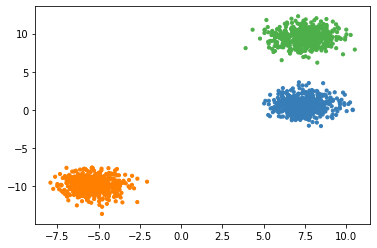

In [312]:
import matplotlib.pyplot as plt
from itertools import cycle, islice 

fig = plt.figure()      
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),int(k))))
plt.scatter(x[:, 0], x[:, 1], s=10, color=colors[labelsPred.tolist()])
plt.show()
# plt.clf()

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle, islice 

fig = plt.figure()      
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),int(k))))
plt.scatter(x1[:, 0], x1[:, 1], s=10, color=colors[labelsPred1.tolist()])
plt.show()
# plt.clf()

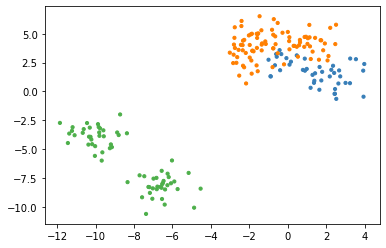

In [21]:
import matplotlib.pyplot as plt
from itertools import cycle, islice 

fig = plt.figure()      
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3',
                                    '#999999', '#e41a1c', '#dede00']),int(k))))
plt.scatter(merged_data.iloc[:, 0].values, merged_data.iloc[:, 1].values, s=10, color=colors[merged_data['label'].astype(int).tolist()])
plt.show()
# plt.clf()

In [28]:
# [labelsPred1.tolist()]